# 0. Imports and standard functions

In [175]:
# importing packages to be used in the notebook
import numpy as np
import numba
from numba import njit
import warnings
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#006BA2','#DB444B','#000000','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from sequence_jacobian import JacobianDict
from scipy.interpolate import interp1d

from types import SimpleNamespace
from tabulate import tabulate

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [176]:
T = 300
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E
    
def manipulate_jac(xi, Js, input_list, output_list, hh_name):
    jac_ = {}
    for output in output_list:
        jac_[output] = {}
        for input in input_list:
            jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))
    return jac_

# 1. Baseline calibration of the model

In [177]:
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

hh_name = hh.name

blocks_ss = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

ss = {}
model = {}

In [178]:
cali_main = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.18, 'bmax': 45, 'rhom': 0.89, 'omega': 0.5, 'q': 0.01,
             'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
             'kappa': 0.01, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}
# cali_main['qh'] = 1.61*4
# cali_main['alpha'] = 0.13
cali_main['alpha'] = 0.05
# cali_main['alpha'] = 0.12
unknowns_ss = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061, 'dbeta': 0.053}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0, 'MPC': 0.12}

ss['baseline'] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
model['baseline'] = hank.steady_state(ss['baseline'])

cali_new = cali_main.copy()
cali_new['qh'] = 2.44*4
ss['qh10'] = hank_ss.solve_steady_state(cali_new, unknowns_ss, targets_ss, solver="hybr")
model['qh10'] = hank.steady_state(ss['qh10'])

In [179]:
print(f"beta_hi: {ss['baseline']['beta_hi']:.3f}, theta: {ss['baseline']['theta']:.3f}, varphi: {ss['baseline']['varphi']:.3f}, dbeta: {ss['baseline']['dbeta']:.3f}")
# print(f"MPC: {ss['baseline']['MPC']:.3f}, qh: {ss['baseline']['qh']:.3f}, qh10: {ss['qh10']['qh']:.3f}")  

print(f"beta_hi: {ss['qh10']['beta_hi']:.3f}, theta: {ss['qh10']['theta']:.3f}, varphi: {ss['qh10']['varphi']:.3f}, dbeta: {ss['qh10']['dbeta']:.3f}")
# print(f"MPC: {ss['baseline']['MPC']:.3f}, qh: {ss['baseline']['qh']:.3f}, qh10: {ss['qh10']['qh']:.3f}")

beta_hi: 0.967, theta: 0.056, varphi: 0.835, dbeta: 0.039
beta_hi: 0.981, theta: 0.092, varphi: 0.835, dbeta: 0.086


# 2. Figures for steady state

In [180]:
H = 10

In [181]:
use_model = model['baseline']

TT = 300
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity = percent_c/percent_qh[0]

M_labor = hh1.jacobian(use_model, inputs=['w'], outputs=['C_BHAT'], T=T)['C_BHAT','w']
impcs = M_labor[:, 0]

In [182]:
use_model = model['qh10']

TT = 300
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity_hw = percent_c/percent_qh[0]

### Figure 1: iMPC out of income

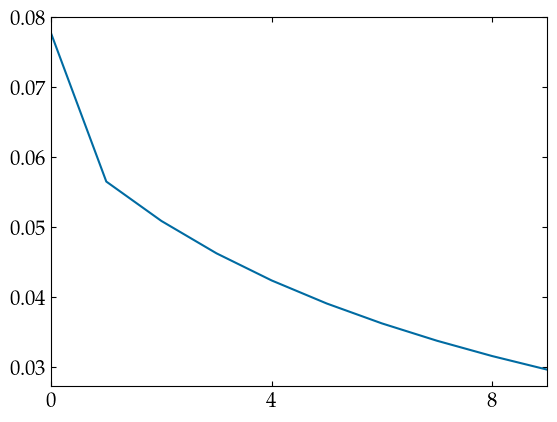

In [183]:
plt.plot(impcs[:H], label='MPC out of income')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# Get the current Axes object
ax = plt.gca()

# Set the major locator for the x-axis
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, H -1)

plt.show()

### Figure 2: Average MPC out of housing

Elasticity at 0: 0.216
MPC at 0: 0.047


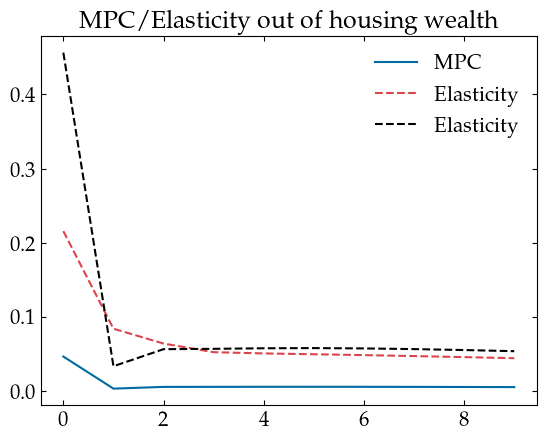

In [184]:
plt.plot(tot['C_BHAT'][:H]/qh[0], label='MPC')
plt.plot(elasticity[:H], label='Elasticity', linestyle='dashed')
plt.plot(elasticity_hw[:H], label='Elasticity', linestyle='dashed')
plt.title('MPC/Elasticity out of housing wealth')
plt.legend(frameon=False)
print(f"Elasticity at 0: {elasticity[0]:.3f}")
print(f"MPC at 0: {tot['C_BHAT'][0]/qh[0]:.3f}")
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)

### Figure 4: MPCH over the distribution

In [185]:
b_grid = model['baseline'].internals[hh_name]['b_bhat_grid']
z_grid = model['baseline'].internals[hh_name]['z_grid']
h_grid = model['baseline'].internals[hh_name]['h_bhat_grid']

bdmargdist = np.sum(model['baseline'].internals[hh_name]['D'], axis=0)
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
h_margdist = np.sum(bdmargdist,axis=0) # sum out bonds
bmargcum = np.cumsum(b_margdist)
hmargcum = np.cumsum(h_margdist)
index_b = np.argmin(np.abs(bmargcum - 0.5))
print(f"Median b: {b_grid[index_b]:.3f} at index {index_b}")
index_h = np.argmin(np.abs(hmargcum - 0.5))
print(f"Median h: {h_grid[index_h]:.3f} at index {index_h}")

Median b: 1.438 at index 18
Median h: 0.693 at index 30


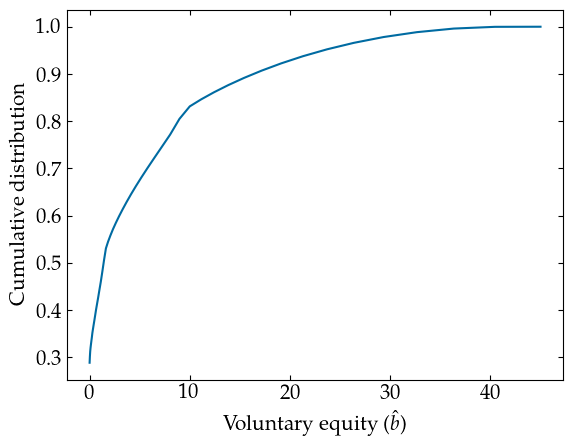

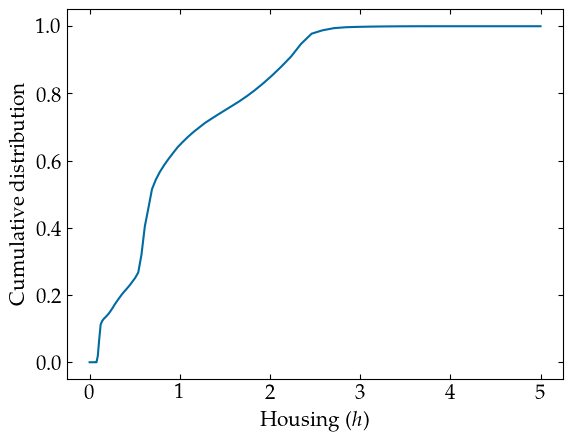

In [201]:
plt.plot(b_grid, bmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.xlabel(r'Voluntary equity ($\hat{b}$)')
plt.ylabel('Cumulative distribution')
plt.show()

plt.plot(h_grid, hmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.xlabel(r'Housing ($h$)')
plt.ylabel('Cumulative distribution')
plt.show()

### Figure 4: MPCH over the distribution

Mean MPC: 0.018
Mean MPC: 0.120


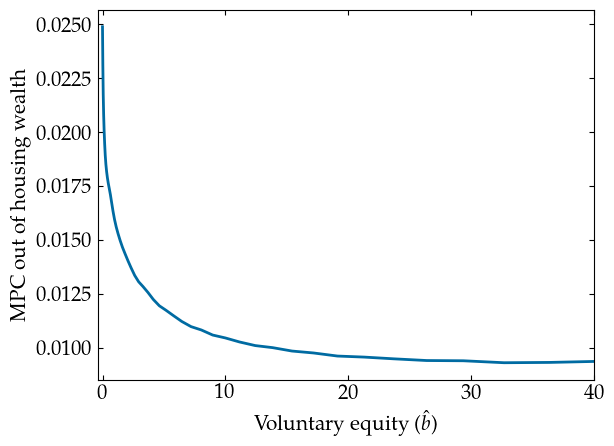

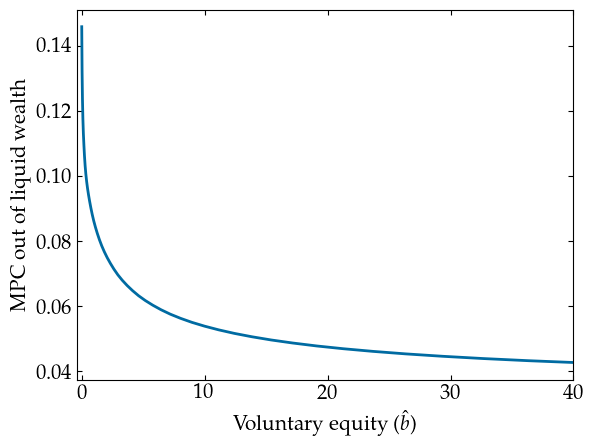

In [223]:
MPCH, mean_MPC = utils.calc_mpch(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

MPC, mean_MPC = utils.calc_mpc(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

z_idx = 1
h_idx = 10
b_idx = 10
# plt.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
# plt.plot(h_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,b_idx,:], label='c')
# plt.plot(b_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,:,index_h], label='c')

fig, ax = plt.subplots()
ax.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of housing wealth')
ax.set_xlim(-0.35, 40)

plt.show()

save = True
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

fig, ax = plt.subplots()
ax.plot(b_grid[:-1], MPC[z_idx,:-1,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# plt.legend(frameon=False)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of liquid wealth')
ax.set_xlim(-0.35, 40)
plt.show()

save = True
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPC_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

# 3. Figures for transition dynamics

In [188]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

In [189]:
H = 17
interval = 2
devss = ['Y', 'qh', 'C_BHAT', 'w', 'N', 'Div', 'Tax', 'CHI']

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

In [190]:
real_rigid = 5
calvo_keep = 0.75 #0.926
calvo_change = 1 - calvo_keep

beta = model['baseline']['omega'] * model['baseline']['beta_hi'] +\
      (1 - model['baseline']['omega']) * (model['baseline']['beta_hi'] - model['baseline']['dbeta'])

kappa = 1 / (1 + real_rigid) * (calvo_change * (1 - beta*calvo_keep)/(calvo_keep))
print(kappa)

0.016068527411913076


In [191]:
irfs = {}

xi = 0.99 # persistence of expectations
rhom = 0.89
# kappa = 0.01
model['baseline']['rhom'] = rhom
model['baseline']['kappa'] = kappa

model['qh10']['rhom'] = rhom
model['qh10']['kappa'] = kappa

model_ss = model['baseline'] # steady state for qh = (baseline)
model_hw = model['qh10'] # steady state for qh = 10

Js = {hh_name: hh2.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}
Js_hw = {hh_name: hh2.jacobian(model_hw, inputs=input_list, outputs=output_list, T=T)}

jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)
jac_hw = manipulate_jac(xi, Js_hw, input_list, output_list, hh_name)

Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}
Js_myopic_hw = {hh_name: JacobianDict(jac_hw, inputs=input_list, outputs=output_list, name='hank')}

irfs['fire'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

irfs['inatt'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

irfs['inatt_hw'] = (hank.solve_jacobian(model_hw, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic_hw, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

### Figure 1: Comparing the response with and without inattention

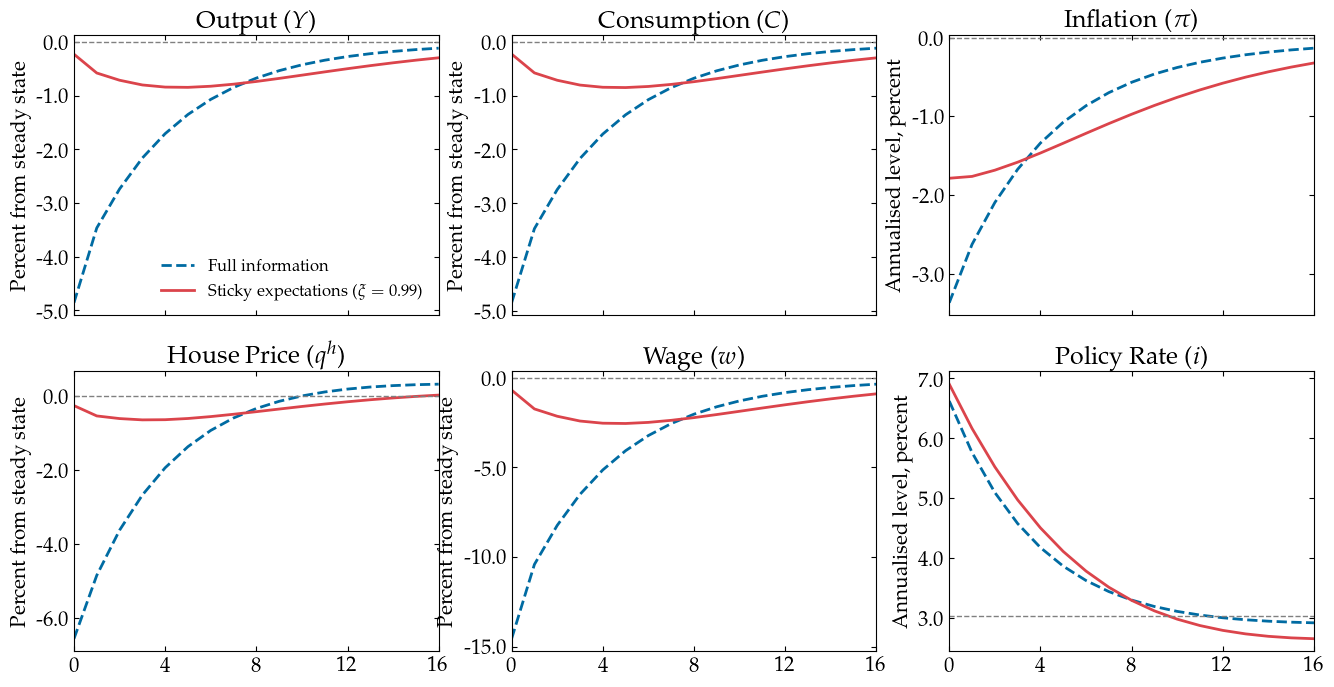

In [192]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['fire']
irf2 = irfs['inatt']
model_ss = model['baseline']

irf3 = irfs['inatt_hw']
model_hw = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), linewidth=2)
        # ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_ss[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend(['Full information',fr'Sticky expectations ($\xi =$ {xi})'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MainModelIrf_v3.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 2: Comparing with empirical IRFs

In [193]:
# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v5.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['i', 'C_BHAT', 'qh', 'Y', 'pi', 'Investment', 'w', 'Mortgage', 'Rent']
df.columns = col_name

bounds_name = ['lb', 'ub']
col_name_bands = []
for i in bounds_name:
    for j in col_name:
        col_name_bands.append(f'{i}_{j}')
df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands.columns = col_name_bands

filename = 'rrshockirfs_v5_68bands.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_bands68 = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands68.columns = col_name_bands

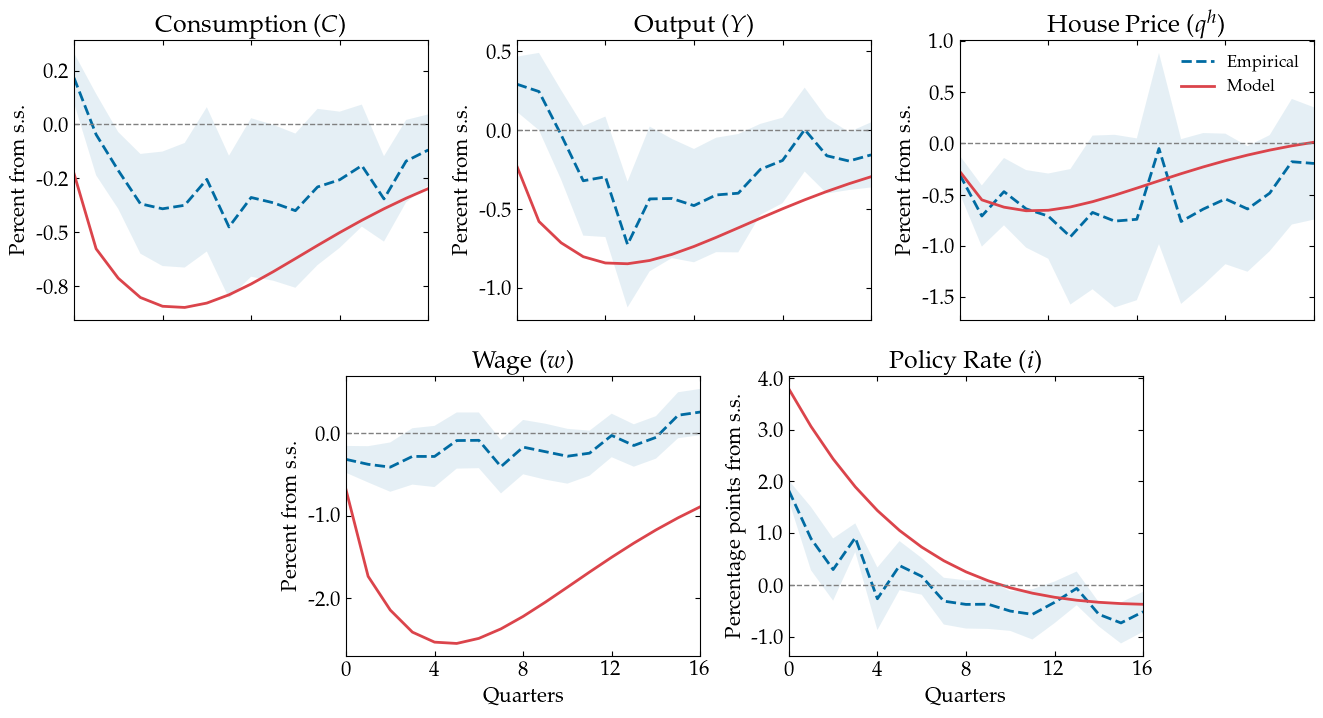

In [194]:
irf2 = irfs['inatt']
model_ss = model['baseline']

fig, ax = plt.subplots(2, 3, figsize=(16*3/3,8), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'Y': 'Output ($Y$)', 'qh': 'House Price ($q^h$)', 
            'w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}


for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*df[key][:H], ls = '--', linewidth=2, color = '#006BA2', label = 'Empirical')
    ax[i].fill_between(range(H), 100*df_bands[f"lb_{key}"][:H], 100*df_bands[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#006BA2', edgecolor = None)

    if key in devss:   
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), linewidth=2, color = '#DB444B', label = 'Model')
    else:
        ax[i].plot(100*((1 + irf2[key][:H])**4-1), linewidth=2, color = '#DB444B', label = 'Model')

    ax[i].set_title(var_name[key])
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))

    if key != 'i':
        ax[i].set_ylabel('Percent from s.s.')
    else:
        ax[i].set_ylabel('Percentage points from s.s.')

    if i == 3 or i == 4:
        ax[i].set_xlabel('Quarters')

    if i == 2:
        ax[i].legend(fontsize=12, frameon=False)

ax[5].axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0.25)
for i in range(3, 5):
    pos = ax[i].get_position()
    ax[i].set_position([pos.x0 + 0.17, pos.y0, pos.width, pos.height])

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ModelEmpiricalComparision_v4.pdf'), dpi=1000, bbox_inches='tight')

### Figure 3: Decomposing the consumption response

In [195]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.baseline = SimpleNamespace()
decomp.hw = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.baseline = SimpleNamespace()
irf.hw = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.baseline, f'dC_d{k}', Js_myopic[hh_name]['C_BHAT'][k] @ irfs['inatt'][k])
    setattr(decomp.hw, f'dC_d{k}', Js_myopic_hw[hh_name]['C_BHAT'][k] @ irfs['inatt_hw'][k])

decomp_dict_baseline = vars(decomp.baseline)
decomp_dict_hw = vars(decomp.hw)

tot_baseline = 0
tot_hw = 0

for (key, value) in decomp_dict_baseline.items():
    tot_baseline += value

for (key, value) in decomp_dict_hw.items():
    tot_hw += value

qh_baseline = decomp.baseline.dC_dqh + decomp.baseline.dC_dqh_lag
qh_hw = decomp.hw.dC_dqh + decomp.hw.dC_dqh_lag
indirect_baseline = decomp.baseline.dC_dN + decomp.baseline.dC_dTax + decomp.baseline.dC_dDiv + decomp.baseline.dC_dw
indirect_hw = decomp.hw.dC_dN + decomp.hw.dC_dTax + decomp.hw.dC_dDiv + decomp.hw.dC_dw
direct_baseline = decomp.baseline.dC_dr
direct_hw = decomp.hw.dC_dr

assert np.allclose(tot_baseline/model['baseline']['C_BHAT'], irfs['inatt']['C_BHAT']/model['baseline']['C_BHAT'])
assert np.allclose(tot_hw/model['qh10']['C_BHAT'], irfs['inatt_hw']['C_BHAT']/model['qh10']['C_BHAT'])

qh_baseline_share = qh_baseline/tot_baseline
indirect_baseline_share = indirect_baseline/tot_baseline
direct_baseline_share = direct_baseline/tot_baseline

qh_hw_share = qh_hw/tot_hw
indirect_hw_share = indirect_hw/tot_hw
direct_hw_share = direct_hw/tot_hw

qh_baseline_cum = np.cumsum(qh_baseline) / np.cumsum(tot_baseline)
indirect_baseline_cum = np.cumsum(indirect_baseline) / np.cumsum(tot_baseline)
direct_baseline_cum = np.cumsum(direct_baseline) / np.cumsum(tot_baseline)

qh_hw_cum = np.cumsum(qh_hw) / np.cumsum(tot_hw)
indirect_hw_cum = np.cumsum(indirect_hw) / np.cumsum(tot_hw)
direct_hw_cum = np.cumsum(direct_hw) / np.cumsum(tot_hw)

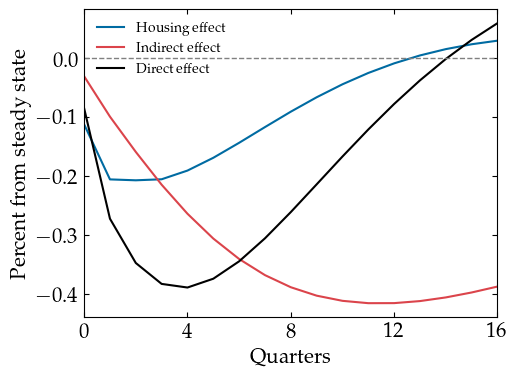

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(16*1/3,4), sharey=True)

plot_total = False

ii = 0
ax.plot(100*qh_baseline[:H]/model['baseline']['C_BHAT'], label='Housing effect')
ax.plot(100*indirect_baseline[:H]/model['baseline']['C_BHAT'], label='Indirect effect')
ax.plot(100*direct_baseline[:H]/model['baseline']['C_BHAT'], label='Direct effect')

if plot_total:
    ax.plot(100*tot_baseline[:H], label='Total (for check)')
    ax.plot(100*(irfs['inatt']['C_BHAT'][:H]), ls = '--', linewidth=2)

# ax.set_title('Consumption Decomposition')
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, 16)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

# ii += 1
# ax.plot(100*decomp.myopic.dC_dN[:H]/ss['C_BHAT'], label=r'Hours ($N$)')
# ax.plot(100*decomp.myopic.dC_dTax[:H]/ss['C_BHAT'], label=r'Tax ($\tau$)')
# ax.plot(100*decomp.myopic.dC_dDiv[:H]/ss['C_BHAT'], label=r'Dividends ($d$)')
# ax.plot(100*decomp.myopic.dC_dw[:H]/ss['C_BHAT'], label=r'Wage ($w$)')
# # ax.set_title('Details of Indirect Effect')
# ax.set_xlabel('Quarters')
# ax.set_ylabel('Percent from steady state')
# ax.xaxis.set_major_locator(MultipleLocator(4))
# ax.set_xlim(0, 16)
# ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
# ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# ax.legend(fontsize=10, frameon=False, ncols=1, loc='center right', bbox_to_anchor=(1, 0.7))

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v2.pdf'), dpi=1000, bbox_inches='tight')

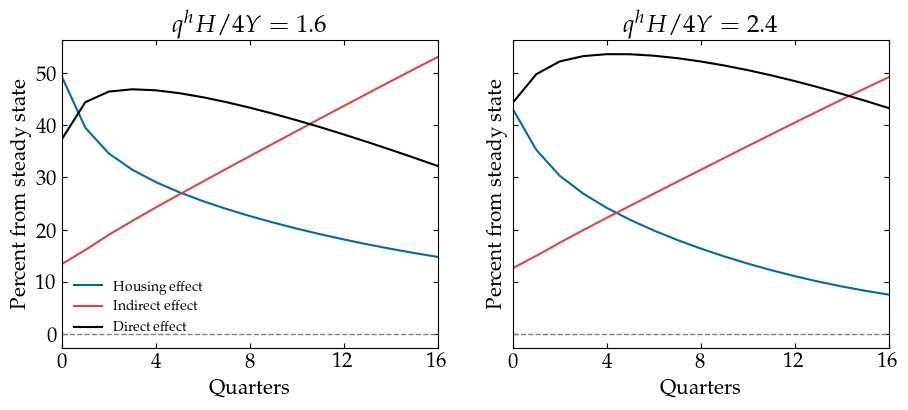

In [197]:
fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharey=True)
ax = ax.flatten()
plot_total = False

ii = 0
ax[ii].plot(100*qh_baseline_cum[:H]/model['baseline']['C_BHAT'], label='Housing effect')
ax[ii].plot(100*indirect_baseline_cum[:H]/model['baseline']['C_BHAT'], label='Indirect effect')
ax[ii].plot(100*direct_baseline_cum[:H]/model['baseline']['C_BHAT'], label='Direct effect')

ii += 1
ax[ii].plot(100*qh_hw_cum[:H]/model['baseline']['C_BHAT'], label='Housing effect')
ax[ii].plot(100*indirect_hw_cum[:H]/model['baseline']['C_BHAT'], label='Indirect effect')
ax[ii].plot(100*direct_hw_cum[:H]/model['baseline']['C_BHAT'], label='Direct effect')

titles = [r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$']
for ii in range(2):
    ax[ii].set_xlabel('Quarters')
    ax[ii].set_ylabel('Percent from steady state')
    ax[ii].xaxis.set_major_locator(MultipleLocator(4))
    ax[ii].set_xlim(0, 16)
    ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    if ii == 0:
        ax[ii].legend(fontsize=10, frameon=False)
    ax[ii].set_title(titles[ii])

# 4. -- Figures for state dependence -- 

### Figure 1: Effects across different wealth levels

In [198]:
# xi = 0.99 # persistence of expectations
# rhom = 0.89
# model['baseline']['rhom'] = rhom
# model['baseline']['kappa'] = kappa

# model_highwealth = model['qh10'] # steady state for qh = 2.6*4

# Js_highwealth = {hh_name: hh2.jacobian(model_highwealth, inputs=input_list, outputs=output_list, T=T)}

# jac_new = manipulate_jac(xi, Js_highwealth, input_list, output_list, hh_name)

# Js_inatt_highwealth = {hh_name: JacobianDict(jac_new, inputs=input_list, outputs=output_list, name='hank')}

# irfs['highwealth'] = (hank.solve_jacobian(model_highwealth, unknowns=unknowns, targets=targets, T=T,
#                                               Js=Js_inatt_highwealth, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

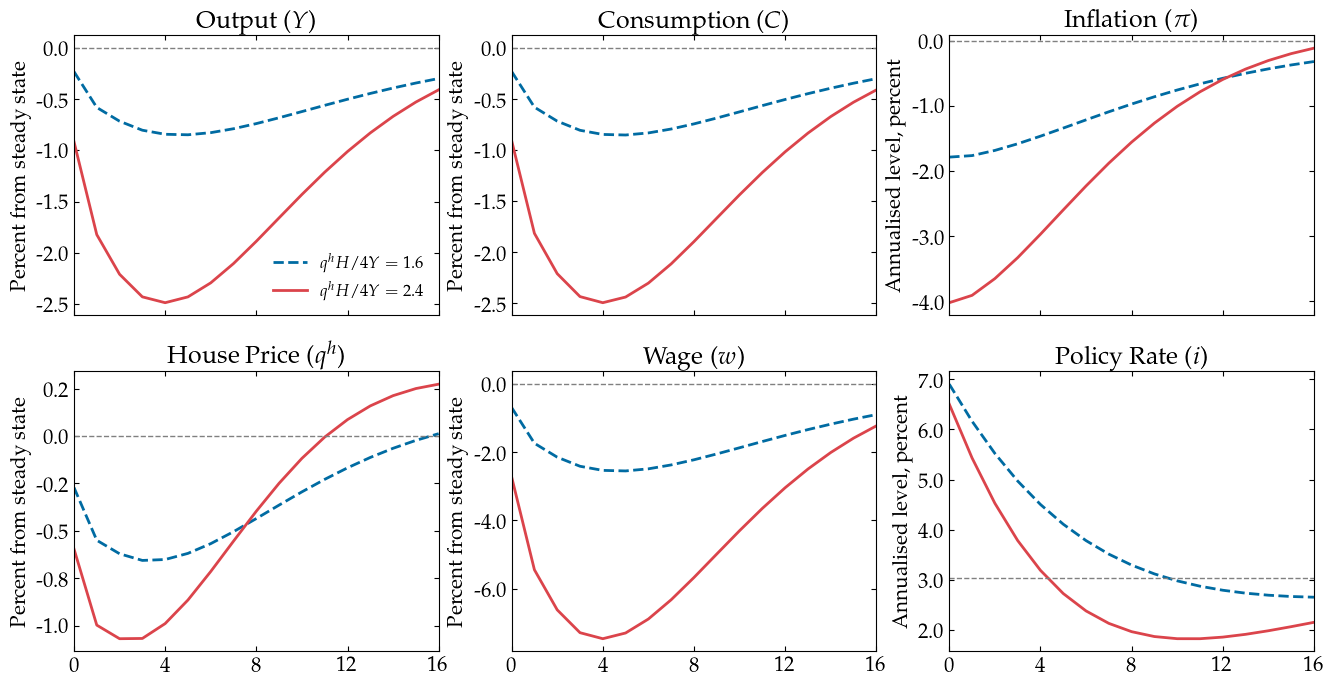

In [199]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['inatt']
irf2 = irfs['inatt_hw']
model_ss = model['baseline']
model_highwealth = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'StateDependence_v2.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 2: Decomposing the effect

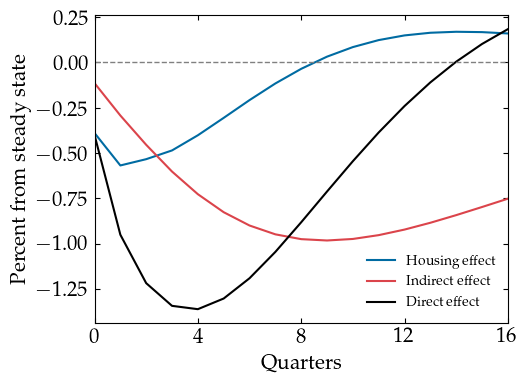

In [200]:
fig, ax = plt.subplots(1, 1, figsize=(16*1/3,4), sharey=True)
plot_total = False

ii = 0
ax.plot(100*qh_hw[:H]/model['baseline']['C_BHAT'], label='Housing effect')
ax.plot(100*indirect_hw[:H]/model['baseline']['C_BHAT'], label='Indirect effect')
ax.plot(100*direct_hw[:H]/model['baseline']['C_BHAT'], label='Direct effect')

if plot_total:
    ax.plot(100*tot_baseline[:H], label='Total (for check)')
    ax.plot(100*(irfs['inatt']['C_BHAT'][:H]), ls = '--', linewidth=2)

# ax.set_title('Consumption Decomposition')
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, 16)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)